In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Library

In [2]:
!pip install timm
!pip install mtcnn
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 15.9 MB/s 
     |████████████████████████████████| 182 kB 70.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 15.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import os
import timm
import random

from mtcnn import MTCNN

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time

from sklearn.cluster import KMeans


device = torch.device('cuda')

# torch model 저장
def model_save(model, score,  path):
    os.makedirs('model', exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'score': score
    }, path)

## Seed 고정

In [4]:
# fix seed

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# 피부색 이미지 모델링

## 이미지 불러오기(피부색 이미지 검출)

In [5]:
#이미지 파일 불러오기

train_imgs = np.load('/content/gdrive/MyDrive/컨퍼런스/final_dataset/seoyoon_train_imgs.npy',allow_pickle=True)
test_imgs = np.load('/content/gdrive/MyDrive/컨퍼런스/final_dataset/seoyoon_test_imgs.npy',allow_pickle=True)

In [6]:
def color(dataset):
  imgs=[]
  for i in dataset:
    r,g,b = cv2.split(i)
    img = cv2.merge([b,g,r])
    img = cv2.fastNlMeansDenoisingColored(img, None, 15,15,7,21)  #디노이징
    img = cv2.medianBlur(img,5)  #bluring 처리4
    #img = cv2.GaussianBlur(img,(5,5),0) #bluring 처리2
    img = cv2.bilateralFilter(img,9,75,75)   #bluring 처리3
    #kernel = np.ones((5,5), np.float32) / 25 #bluring 처리1
    #img = cv2.filter2D(img, -1, kernel)
    imgs.append(img)
  return np.array(imgs)

In [7]:
train_imgs = color(train_imgs)
test_imgs = color(test_imgs)

In [8]:
#labeling
train_jpg = sorted(glob('/content/gdrive/MyDrive/컨퍼런스/total_dataset/train/*/*'))
test_jpg = sorted(glob('/content/gdrive/MyDrive/컨퍼런스/total_dataset/test/*/*'))

In [9]:
train_jpg[0].split("/")[-2]

'fall'

In [10]:
# Train 라벨만 추출
train_labels = []
for i in train_jpg:
    train_labels.append(i.split('/')[-2])

# Test 라벨만 추출
test_labels = []
for i in test_jpg:
    test_labels.append(i.split('/')[-2])

In [11]:
# Label encoding
for i in range(len(train_labels)):
  if train_labels[i] == 'spring':
    train_labels[i] = 0
  elif train_labels[i] == 'summer':
    train_labels[i] = 1
  elif train_labels[i] == 'fall':
    train_labels[i] = 2
  else:
    train_labels[i] = 3

In [12]:
for i in range(len(test_labels)):
  if test_labels[i] == 'nspring':
    test_labels[i] = 0
  elif test_labels[i] == 'nsummer':
    test_labels[i] = 1
  elif test_labels[i] == 'nfall':
    test_labels[i] = 2
  else:
    test_labels[i] = 3

In [13]:
print(len(train_imgs), len(train_labels))
print(len(test_imgs), len(test_labels))

421 421
40 40


## 얼굴 탐지, 피부 검출 및 이미지 resize

In [ ]:
def img_face_detect(path):
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    detections = detector.detect_faces(img)
    bounding_box = list(detections[0].values())
    
    def im_trim (img): #함수로 만든다
        x = bounding_box[0][0]; y = bounding_box[0][1]; #자르고 싶은 지점의 x좌표와 y좌표 지정
        w = bounding_box[0][2]; h = bounding_box[0][3]; #x로부터 width, y로부터 height를 지정
        img_trim = img[y:y+h, x:x+w] #trim한 결과를 img_trim에 담는다
        return img_trim #필요에 따라 결과물을 리턴

    trim_image = im_trim(img)
    
    trim_image = cv2.resize(trim_image, (256, 256),interpolation = cv2.INTER_AREA)
    
    r,g,b = cv2.split(trim_image)
    trim_image = cv2.merge([b,g,r])

    face_img_ycrcb = cv2.cvtColor(trim_image, cv2.COLOR_BGR2YCrCb)

    lower = np.array([0,133,77], dtype = np.uint8)
    upper = np.array([255,173,127], dtype = np.uint8)
    skin_msk = cv2.inRange(face_img_ycrcb, lower, upper) #OpenCV의 inRange함수는 
                                                         #특정 이미지 데이터의 상/하한선을 정해놓고 그 안에 들어오는 pixel들은 1로,
                                                         #나머지 pixel들은 0으로 만들겠다 라는 함수 입니다.
        
    skin = cv2.bitwise_and(trim_image, trim_image, mask = skin_msk)
    b,g,r = cv2.split(skin)
    skin = cv2.merge([r,g,b])
    return skin
#    return trim_image

In [ ]:
train_imgs = [img_face_detect(m) for m in tqdm(train_jpg)]
test_imgs = [img_face_detect(n) for n in tqdm(test_jpg)]

100%|██████████| 161/161 [05:10<00:00,  1.93s/it]


(-0.5, 169.5, 214.5, -0.5)

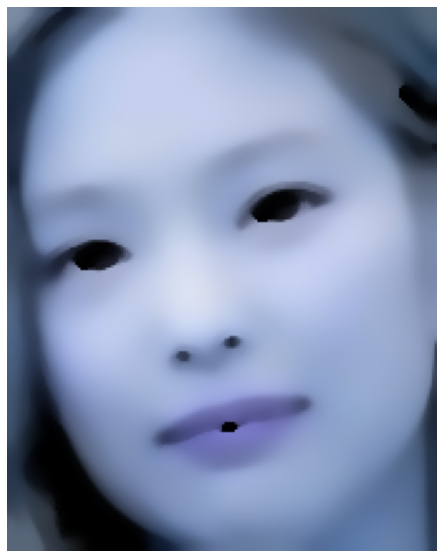

In [31]:
import matplotlib.pylab as plt

#피부 이미지 확인
plt.figure(figsize = (10,10))
plt.imshow(train_imgs[4])
plt.axis('off')

In [ ]:
#npy파일로 이미지 저장

np.save('train_imgs_new', np.array(train_imgs))
np.save('test_imgs_new', np.array(test_imgs))

In [17]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [62]:
#데이터 셋 구성

class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode == 'train':
          train_transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Resize((128, 128)),
                #transforms.ColorJitter(brightness=0.6, hue=0.3),
                #transforms.RandomAffine((-45, 45)),
                #transforms.RandomHorizontalFlip(),
                #transforms.RandomVerticalFlip(),
            ])
          img = train_transform(img)
        if self.mode == 'test':
          test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((128, 128)),
                #transforms.ColorJitter(brightness=0.6, hue=0.3),
                #transforms.RandomAffine((-45, 45)),
                #transforms.RandomHorizontalFlip(),
                #transforms.RandomVerticalFlip(),
            ])
          img = test_transform(img)

        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self,mode = 'train'):
        super(Network, self).__init__()
        self.mode = mode
        if self.mode == 'train':
          self.model = timm.create_model('resnet18', pretrained=True, num_classes=4, drop_path_rate = 0.1)
                                         
        if self.mode == 'test':
          self.model = timm.create_model('resnet18', pretrained=True, num_classes=4, drop_path_rate = 0)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [54]:
# KFold
folds = []
kf = KFold(n_splits=6, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(train_imgs):
    folds.append((train_idx, valid_idx))
fold=0
train_idx, valid_idx = folds[fold]


batch_size = 10
epochs = 25


# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)

# Validation 
valid_dataset = Custom_dataset(np.array(train_imgs)[valid_idx], np.array(train_labels)[valid_idx], mode='valid')
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, pin_memory=True)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, pin_memory=True)

In [55]:
#평가지표

def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

## 학습!

In [56]:
import gc

cv = StratifiedKFold(n_splits = 6, random_state = 42,shuffle=True)
batch_size = 10
epochs = 25
pred_ensemble = []


for idx, (train_idx, val_idx) in enumerate(cv.split(train_imgs, np.array(train_labels))):
  print("----------fold_{} start!----------".format(idx))
  t_imgs, val_imgs = train_imgs[train_idx],  train_imgs[val_idx]
  t_labels, val_labels = np.array(train_labels)[train_idx], np.array(train_labels)[val_idx]

  # Train
  train_dataset = Custom_dataset(np.array(t_imgs), np.array(t_labels), mode='train')
  train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

  # Val
  val_dataset = Custom_dataset(np.array(val_imgs), np.array(val_labels), mode='test')
  val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

  gc.collect()
  torch.cuda.empty_cache()
  best=0

  model = Network().to(device)

  optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay = 1e-2)
  criterion = nn.CrossEntropyLoss()
  scaler = torch.cuda.amp.GradScaler()  

  best_f1 = 0
  early_stopping = 0
  for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
    train_f1 = score_function(train_y, train_pred)
    state_dict= model.state_dict()
    model.eval()
    with torch.no_grad():
      val_loss = 0 
      val_pred = []
      val_y = []
      

      for batch in (val_loader):
        x_val = torch.tensor(batch[0], dtype = torch.float32, device = device)
        y_val = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred_val = model(x_val)
        loss_val = criterion(pred_val, y_val)

        val_loss += loss_val.item()/len(val_loader)
        val_pred += pred_val.argmax(1).detach().cpu().numpy().tolist()
        val_y += y_val.detach().cpu().numpy().tolist()
      val_f1 = score_function(val_y, val_pred)

      if val_f1 > best_f1:
        best_epoch = epoch
        best_loss = val_loss
        best_f1 = val_f1
        early_stopping = 0

        torch.save({'epoch':epoch,
                    'state_dict':state_dict,
                    'optimizer': optimizer.state_dict(),
                    'scaler': scaler.state_dict(),
             }, 'best_model_{}.pth'.format(idx))
        print('-----------------SAVE:{} epoch----------------'.format(best_epoch+1))
      else:
          early_stopping += 1

            # Early Stopping
      if early_stopping == 20:
        TIME = time.time() - start
        print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
        print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
        print(f'Val    loss : {val_loss:.5f}    f1 : {val_f1:.5f}')
        break

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
    print(f'Val    loss : {val_loss:.5f}    f1 : {val_f1:.5f}')

----------fold_0 start!----------
-----------------SAVE:1 epoch----------------
epoch : 1/25    time : 2s/39s
TRAIN    loss : 1.73785    f1 : 0.31821
Val    loss : 1.30383    f1 : 0.41972
-----------------SAVE:2 epoch----------------
epoch : 2/25    time : 2s/38s
TRAIN    loss : 1.18866    f1 : 0.49214
Val    loss : 1.29907    f1 : 0.47493
epoch : 3/25    time : 1s/30s
TRAIN    loss : 1.04459    f1 : 0.55917
Val    loss : 1.49872    f1 : 0.43605
epoch : 4/25    time : 2s/33s
TRAIN    loss : 0.81259    f1 : 0.65128
Val    loss : 1.40533    f1 : 0.42217
epoch : 5/25    time : 2s/36s
TRAIN    loss : 0.89238    f1 : 0.68269
Val    loss : 1.27814    f1 : 0.47094
-----------------SAVE:6 epoch----------------
epoch : 6/25    time : 2s/35s
TRAIN    loss : 0.75620    f1 : 0.70154
Val    loss : 1.45856    f1 : 0.49675
epoch : 7/25    time : 1s/24s
TRAIN    loss : 0.70277    f1 : 0.74684
Val    loss : 2.00562    f1 : 0.34475
epoch : 8/25    time : 1s/22s
TRAIN    loss : 0.58453    f1 : 0.77141
Va

## 추론!

In [57]:
pred_ensemble = []
batch_size = 7

for i in range(6):
  model_test = Network(mode = 'test').to(device)
  model_test.load_state_dict(torch.load(('best_model_{}.pth'.format(i)))['state_dict'])
  model_test.eval()
  pred_prob = []
  with torch.no_grad():
      for batch in (test_loader):
          x = torch.tensor(batch[0], dtype = torch.float32, device = device)
          with torch.cuda.amp.autocast():
              pred = model_test(x)
              pred_prob.extend(pred.detach().cpu().numpy())
      pred_ensemble.append(pred_prob)

In [58]:
pred = (np.array(pred_ensemble[0])+ np.array(pred_ensemble[1]) + np.array(pred_ensemble[2]) + np.array(pred_ensemble[3]) + np.array(pred_ensemble[4]) + np.array(pred_ensemble[5]))/6
f_pred = np.array(pred).argmax(1).tolist()

In [59]:
score_function(test_labels, f_pred)

0.6211797609966947

In [60]:
print(f_pred)

[2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 3, 0, 1, 0, 0, 0, 3, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 1, 3, 3, 2, 0, 2, 0, 3, 3, 1, 1]


In [61]:
print(test_labels)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:

label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

In [ ]:
submission = pd.read_csv("sample_submission.csv")

submission["pred_label"] = f_result

submission 

# 피부색 및 퍼스널 컬러 요소 피처 모델링

In [ ]:
train_x = pd.read_csv("aftrain_label.csv")
test_x = pd.read_csv("startest_label.csv")

In [ ]:
display(train_x)
display(test_x)

In [ ]:
train_x = train_x[['채도','명도','최종라벨']]
train_y = train_x['최종라벨']
train_x = train_x.drop(columns=['최종라벨'])

test_x = test_x[['파일명','채도','명도','최종라벨']]
test_y = test_x['최종라벨']
test_x = test_x.drop(columns=['최종라벨'])

In [ ]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

RGB_list = []
for i in range(train_imgs.shape[0]):
    image = train_imgs[i]
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters = 5)
    clt.fit(image)
    hist = centroid_histogram(clt)
    tmp = max(hist)
    index = list(hist).index(tmp)
    RGB_list.append(clt.cluster_centers_[index])

In [ ]:
columns = ['R_value','G_value','B_value']

In [ ]:
train_df = pd.DataFrame(RGB_list, columns=columns)

In [ ]:
train_df = train_df.abs()

In [ ]:
train_df['V_value'] = train_df.max(axis=1)
train_df['min_rgb'] = train_df.min(axis=1)
train_df['S_value'] = (train_df['V_value'] - train_df['min_rgb'])/train_df['V_value']

In [ ]:
if (train_df['V_value'] == train_df['R_value']).any():
    train_df['H_value'] = 60 * (train_df['G_value'] - train_df['B_value']) / (train_df['V_value'] - train_df['min_rgb'])
elif (train_df['V_value'] == train_df['G_value']).any():
    train_df['H_value'] = 120 + (60 * (train_df['B_value'] - train_df['R_value'])) / (train_df['V_value'] - train_df['min_rgb'])
elif (train_df['V_value'] == train_df['B_value']).any():
    train_df['H_value'] = 240 + (60 * (train_df['R_value'] - train_df['G_value'])) / (train_df['V_value'] - train_df['min_rgb'])
    
if (train_df['H_value'] < 0).any():
    train_df['H_value'] += 360
train_df['H_value'] /= 360

In [ ]:
train_df = train_df.fillna(0)

In [ ]:
RGB_list = []
for i in range(test_imgs.shape[0]):
    image = test_imgs[i]
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters = 5)
    clt.fit(image)
    hist = centroid_histogram(clt)
    tmp = max(hist)
    index = list(hist).index(tmp)
    RGB_list.append(clt.cluster_centers_[index])

In [ ]:
test_df = pd.DataFrame(RGB_list, columns=columns)

In [ ]:
test_df = test_df.abs()

In [ ]:
test_df['V_value'] = test_df.max(axis=1)
test_df['min_rgb'] = test_df.min(axis=1)
test_df['S_value'] = (test_df['V_value'] - test_df['min_rgb'])/test_df['V_value']

In [ ]:
if (test_df['V_value'] == test_df['R_value']).any():
    test_df['H_value'] = 60 * (test_df['G_value'] - test_df['B_value']) / (test_df['V_value'] - test_df['min_rgb'])
elif (test_df['V_value'] == test_df['G_value']).any():
    test_df['H_value'] = 120 + (60 * (test_df['B_value'] - test_df['R_value'])) / (test_df['V_value'] - test_df['min_rgb'])
elif (test_df['V_value'] == test_df['B_value']).any():
    test_df['H_value'] = 240 + (60 * (test_df['R_value'] - test_df['G_value'])) / (test_df['V_value'] - test_df['min_rgb'])
    
if (test_df['H_value'] < 0).any():
    test_df['H_value'] += 360
test_df['H_value'] /= 360

In [ ]:
test_df = test_df.fillna(0)

In [ ]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, stratify=train_y, test_size=0.3, random_state=0)

In [ ]:
from sklearn.metrics import *

In [ ]:
from sklearn.preprocessing import StandardScaler    
sclaer = StandardScaler()    
x_train= sclaer.fit_transform(train_df)    
x_test= sclaer.transform(test_df) 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier()  
classifier.fit(train_x, train_y) 

In [ ]:
pred = classifier.predict(test_x)
score = accuracy_score(test_y, pred)
print(score)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier= DecisionTreeClassifier()
classifier.fit(x_train, train_labels)

In [ ]:
y_pred= classifier.predict(x_test)

#label_decoder = {val:key for key, val in label_unique.items()}
#f_result = [label_decoder[result] for result in y_pred]

submission = pd.read_csv("sample_submission.csv")
submission["pred_label"] = y_pred
submission 

In [ ]:
#정확도

submission['target'] = (submission['real_label'] == submission['pred_label']).astype(int)
submission['target'].sum()/submission['target'].shape[0]

In [ ]:
def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

bar = plot_colors(hist, clt.cluster_centers_)


# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [ ]:
#정확도

submission['target'] = (submission['real_label'] == submission['pred_label']).astype(int)
submission['target'].sum()/submission['target'].shape[0]

In [ ]:
submission.to_csv("test.csv", index = False)